## YahooStocks Multiple Security Downloader

In [285]:
# Stock Downloader Yahoo In-Memory / Python 3
def YahooStocks(tickers = ["FB", "MSFT"], freq = "d", selectColumn = "AdjClose", fromDate = None, toDate = None, lagPeriods = 1):
    
    """
    NOTES:
    tickers = Defaults to ["MSFT","FB"], and uses a list as input
    freq = Defaults to "d" (Note: Can be "d"[daily],"m"[monthly],"q"[quarterly], or "v"[dividends])
    selectColumn = Defaults to "AdjClose". Can choose between "Open", "High", "Low", "Close", "Volume" or "AdjClose".
    fromDate: Defaults to 1yr lag. Must include YYYY/MM/DD or YYYY-MM-DD string as format.
    toDate: Defaults to 1yr lag. Must include YYYY/MM/DD or YYYY-MM-DD string as format.
    lagPeriods: Lag periods default to 1. If they are greater than the frame, a warning will be returned.
    
    """
    import pandas as pd
    import datetime
    # For downloader
    import urllib.request
    import io
    import urllib.error
    import numpy as np
    
    stackData = pd.DataFrame()
    fullData = pd.DataFrame()
    fullDataClean = pd.DataFrame()
    
    tickers = sorted(tickers) # For matching tables, have to sort first
    for ticker in tickers:
        
        data = pd.DataFrame() 
        fromDateInternal = pd.DataFrame() 
        toDateInternal = pd.DataFrame()
        tickersNarrow = pd.DataFrame()

        url = []
        xld = []
        xlds = []


        if fromDate is None:

            toDateInternal = datetime.datetime.now()
            fromDateInternal = toDateInternal - datetime.timedelta(days=360)

            toDateInternal  = str(toDateInternal.date())
            toDateInternal = toDateInternal.replace('-', '/')
            toDateInternal = pd.to_datetime(toDateInternal, format = "%Y/%m/%d").date()


            fromDateInternal  = str(fromDateInternal.date())
            fromDateInternal = fromDateInternal.replace('-', '/')
            fromDateInternal = pd.to_datetime(fromDateInternal, format = "%Y/%m/%d").date()

        else:
            

            fromDateInternal = fromDate
            fromDateInternal = fromDateInternal.replace('-', '/')
            fromDateInternal = datetime.datetime.strptime(fromDateInternal, "%Y/%m/%d").date()


            if toDate == None: 
                toDateInternal = str(datetime.datetime.now().date())
                toDateInternal = toDateInternal.replace('-', '/')
                toDateInternal = datetime.datetime.strptime(toDateInternal, "%Y/%m/%d").date()

            else:
                toDateInternal  = str(toDate)
                toDateInternal = toDateInternal.replace('-', '/')
                toDateInternal = datetime.datetime.strptime(toDateInternal, "%Y/%m/%d").date()

        #print(fromDateInternal)
        #print(toDateInternal)
        
        # Downloader
        url = "http://real-chart.finance.yahoo.com/table.csv?s=" + ticker + "&a=0" + str(fromDateInternal.month) + "&b=" + \
            str(fromDateInternal.day) + "&c=" + str(fromDateInternal.year) + "&d=0" + str(toDateInternal.month) + "&e="  +  \
                str(toDateInternal.day) + "&f=" +  str(toDateInternal.year) + "&g=" + freq + "&ignore=.csv"

        #Checks if 404 error from no data in ticker
        try:
            
            # Download and read in as csv from memory
            xld = urllib.request.urlopen(url).read()
            xld = xld.decode('utf-8')
            xlds = io.StringIO(xld)
            data = pd.read_csv(xlds, delimiter=',', header=None, skiprows=1)
            xlds.close()
            
            data.columns = ["Date", "Open", "High", "Low", "Close", "Volume", "AdjClose"]

            data['Date'] = pd.to_datetime(data['Date'], format = "%Y-%m-%d")
            data[["Open", "High", "Low", "Close", "Volume", "AdjClose"]] = data[["Open", "High", "Low", "Close", "Volume", "AdjClose"]].astype(float)
            data["Security"] = ticker

            stackData = pd.concat([stackData, data])
            
            print(ticker, ": ", url)

            
        except urllib.error.HTTPError as err:
            print(ticker, ": No data for ticker exists in the given date range")
            if err.code == 404:
                continue
            else:
                raise
                
    ## Find all dates and create index
    # Returns all dates among used ticker data
    uniqueDates = stackData.Date.map(lambda t: t.date()).unique()
    uniqueDates = pd.DataFrame(uniqueDates, columns = ['Date'] ).sort_values(by = "Date", ascending = [0])
    uniqueDates['Date'] = pd.to_datetime(uniqueDates['Date'], format = "%Y-%m-%d")

    fullData = uniqueDates
    
    tickersNarrow = stackData.Security.unique() # Find usable tickers
    
    ## Loop through each ticker
    for tickerTemp in tickersNarrow:
        fullData = pd.merge(fullData, stackData[stackData.Security==tickerTemp][['Date',selectColumn]], on = "Date", how = 'left')
        fullData.rename(columns={selectColumn:(tickerTemp + "_" + selectColumn)}, inplace = True)     
        
    # Drop any rows with NaN
    fullDataClean = fullData.dropna()
    
    print()
    print( "fullData Dates range from: ", min(fullData.Date).date(), " to ", max(fullData.Date).date() )
    print( "fullDataClean Dates range from: ", min(fullDataClean.Date).date(), " to ", max(fullDataClean.Date).date() )
    print()
    print("Lengths of each security(for gauging optimal groups):")
    print(len(fullData) - fullData.isnull().sum())
    
    ## Create simple and log returns
    fullDataCleanLn = pd.concat([fullDataClean.Date, np.log(fullDataClean[fullDataClean.columns.difference(['Date'])].pct_change(periods = -lagPeriods) + 1)], axis=1).dropna()
    fullDataCleanSimple = pd.concat([fullDataClean.Date, fullDataClean[fullDataClean.columns.difference(['Date'])].pct_change(periods = -lagPeriods)], axis = 1).dropna()
    # Clean names of returns
    fullDataCleanSimple = fullDataCleanSimple.rename(columns={col: col.replace(selectColumn, "SimpleReturns") for col in fullDataCleanSimple.columns})
    fullDataCleanLn = fullDataCleanLn.rename(columns={col: col.replace(selectColumn, "LnReturns") for col in fullDataCleanLn.columns})

    if len(fullDataCleanLn) == 0:
        print()
        print('Warning: We recommend shorter lag periods to return an adequate return sample')
        
    ## Return all objects
    return fullData, fullDataClean, stackData, fullDataCleanSimple, fullDataCleanLn


In [299]:
## Run the Function

#     freq = Defaults to "d" (Note: Can be "d"[daily],"m"[monthly],"q"[quarterly], or "v"[dividends])
#     selectColumn = Defaults to "AdjClose". Can choose between "Open", "High", "Low", "Close", "Volume" or "AdjClose".
#     fromDate: Defaults to 1yr lag. Must include YYYY/MM/DD or YYYY-MM-DD string as format.
#     toDate: Defaults to 1yr lag. Must include YYYY/MM/DD or YYYY-MM-DD string as format.
#     lagPeriods: Lag periods default to 1. If they are greater than the frame, a warning will be returned.

tickers = ['GOOG', 'C',"F", "MSFT"]
fullData, fullDataClean, stackData, fullDataCleanSimple, fullDataCleanLn = \
    YahooStocks(tickers, freq = "d", selectColumn = "AdjClose", fromDate = "1990/01/01", toDate = "2016/01/01", lagPeriods = 252) 

C :  http://real-chart.finance.yahoo.com/table.csv?s=C&a=01&b=1&c=1990&d=01&e=1&f=2016&g=d&ignore=.csv
F :  http://real-chart.finance.yahoo.com/table.csv?s=F&a=01&b=1&c=1990&d=01&e=1&f=2016&g=d&ignore=.csv
GOOG :  http://real-chart.finance.yahoo.com/table.csv?s=GOOG&a=01&b=1&c=1990&d=01&e=1&f=2016&g=d&ignore=.csv
MSFT :  http://real-chart.finance.yahoo.com/table.csv?s=MSFT&a=01&b=1&c=1990&d=01&e=1&f=2016&g=d&ignore=.csv

fullData Dates range from:  1990-02-01  to  2016-02-01
fullDataClean Dates range from:  2004-08-19  to  2016-02-01

Lengths of each security(for gauging optimal groups):
Date             6551
C_AdjClose       6551
F_AdjClose       6551
GOOG_AdjClose    2883
MSFT_AdjClose    6551
dtype: int64


In [300]:
# print(fullData.columns)
# print(fullDataClean.columns)
# print(stackData.columns)
# print(fullDataCleanSimple.columns)
# print(fullDataCleanLn.columns)

In [301]:
fullDataClean.head()

,Date,C_AdjClose,F_AdjClose,GOOG_AdjClose,MSFT_AdjClose
0,2016-02-01,42.435122,11.938327,752.000000,53.942693
1,2016-01-29,42.535019,11.809745,742.950012,54.317364
2,2016-01-28,40.347330,11.582255,730.960022,51.329861
3,2016-01-27,40.467206,11.720728,699.989990,50.501642
4,2016-01-26,40.407341,11.730619,713.039978,51.438315


In [302]:
fullDataClean.tail()

,Date,C_AdjClose,F_AdjClose,GOOG_AdjClose,MSFT_AdjClose
2878,2004-08-25,379.959291,10.971897,52.947145,19.174246
2879,2004-08-24,376.840845,10.932599,52.382705,18.958492
2880,2004-08-23,376.020198,11.034773,54.645447,18.958492
2881,2004-08-20,377.087029,11.089790,54.100990,18.874975
2882,2004-08-19,373.065866,11.003335,50.119968,18.819461


## Plot Multiline Data

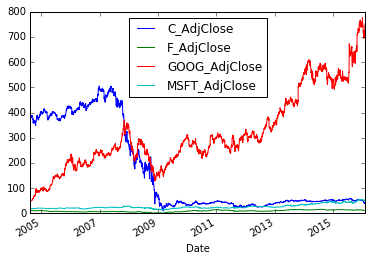

In [303]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.figure 
%matplotlib inline

plt.figure(num=1, figsize=(20, 20))

# Nominal Prices
fullDataClean.plot(x = 'Date')

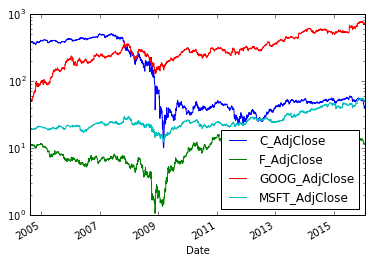

In [304]:
# Ln Prices (Easier to view in tandem)
fullDataClean.plot(x = 'Date', loglog = True)

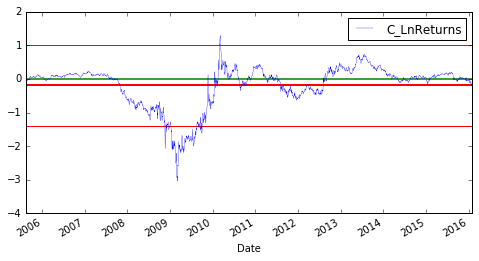

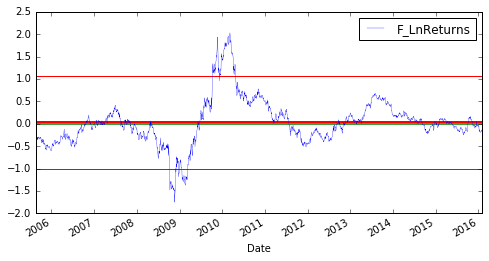

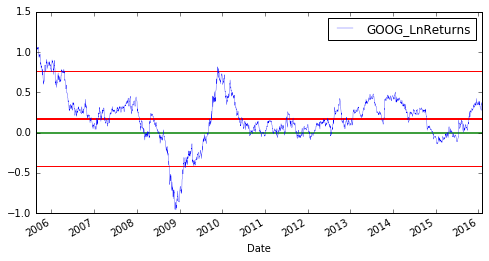

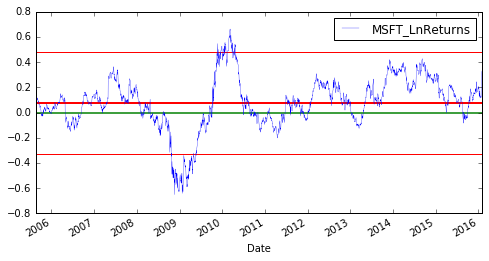

In [305]:
# Ln YOY Returns with 1.96 Standard Deviations
from pandas import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

for colName in fullDataCleanLn[fullDataCleanLn.columns.difference(['Date'])].columns:
    ts = fullDataCleanLn[["Date", colName]]
    ts.plot(kind='line', x = 'Date', loglog = False, linewidth = .3, figsize=(8,4))
    plt.axhline(y = np.mean(ts[colName], axis = 0), c = "red", linewidth = 2, zorder = 0)
    plt.axhline(y = np.mean(ts[colName], axis = 0) + 1.96*np.std(ts[colName], axis = 0), c = "red", linewidth = 1, zorder = 0)
    plt.axhline(y = np.mean(ts[colName], axis = 0) - 1.96*np.std(ts[colName], axis = 0), c = "red", linewidth = 1, zorder = 0)
    plt.axhline(y = 0, c = "green", linewidth = 1.5, zorder = 0)
    plt.show()
    

## Save as Workbook

In [306]:
# Write to XLSX 
writer = pd.ExcelWriter('MultipleSecurities.xlsx')
fullDataClean.to_excel(writer,'fullDataClean')
fullData.to_excel(writer,'fullData')
stackData.to_excel(writer,'stackData')
fullDataCleanSimple.to_excel(writer,'fullDataCleanSimple')
fullDataCleanLn.to_excel(writer,'fullDataCleanLn')
writer.save()
